<a href="https://colab.research.google.com/github/3monochloride4/Bangkit-Capstone-Project-repo/blob/main/ML_model_precipitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
!pip install tensorflowjs

     |████████████████████████████████| 71kB 8.2MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

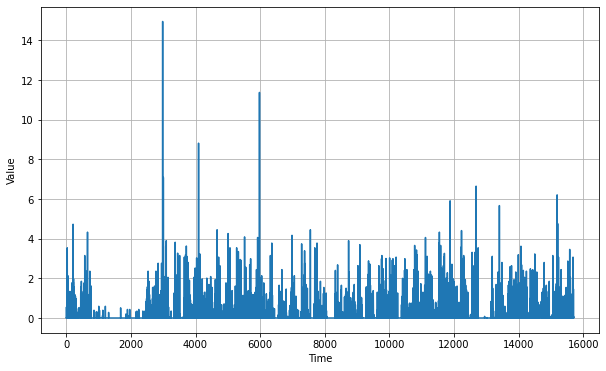

In [ ]:
import csv
i=1
time_step = []
precipitation = []

with open('/tmp/datasetCuacaSmg1957-2021fix.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    precipitation.append(float(row[4]))
    time_step.append(i)
    i+=1

series = np.array(precipitation)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 15000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 80
batch_size = 200
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(15000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
75/75 [==============================] - 37s 33ms/step - loss: 0.5699 - mae: 0.8639
Epoch 2/100
75/75 [==============================] - 2s 32ms/step - loss: 0.5211 - mae: 0.8417
Epoch 3/100
75/75 [==============================] - 3s 32ms/step - loss: 0.4907 - mae: 0.8055
Epoch 4/100
75/75 [==============================] - 3s 32ms/step - loss: 0.4614 - mae: 0.7620
Epoch 5/100
75/75 [==============================] - 3s 33ms/step - loss: 0.4336 - mae: 0.7182
Epoch 6/100
75/75 [==============================] - 3s 32ms/step - loss: 0.4075 - mae: 0.6756
Epoch 7/100
75/75 [==============================] - 3s 32ms/step - loss: 0.3830 - mae: 0.6349
Epoch 8/100
75/75 [==============================] - 3s 32ms/step - loss: 0.3597 - mae: 0.6010
Epoch 9/100
75/75 [==============================] - 3s 33ms/step - loss: 0.3380 - mae: 0.5751
Epoch 10/100
75/75 [==============================] - 3s 32ms/step - loss: 0.3182 - mae: 0.5549
Epoch 11/100
75/75 [============================

(1e-08, 0.0001, 0.0, 20.0)

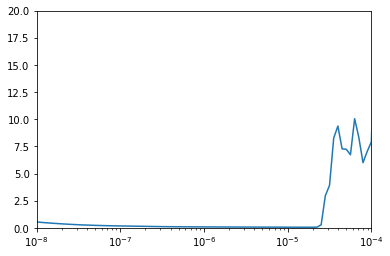

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 20])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=80, batch_size=200, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", 'accuracy'])
history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
75/75 [==============================] - 5s 33ms/step - loss: 0.1457 - mae: 0.3263 - accuracy: 0.7007
Epoch 2/100
75/75 [==============================] - 2s 31ms/step - loss: 0.0744 - mae: 0.2024 - accuracy: 0.7343
Epoch 3/100
75/75 [==============================] - 3s 33ms/step - loss: 0.0727 - mae: 0.1992 - accuracy: 0.7336
Epoch 4/100
75/75 [==============================] - 3s 34ms/step - loss: 0.0718 - mae: 0.1979 - accuracy: 0.7333
Epoch 5/100
75/75 [==============================] - 3s 34ms/step - loss: 0.0710 - mae: 0.1961 - accuracy: 0.7335
Epoch 6/100
75/75 [==============================] - 3s 34ms/step - loss: 0.0704 - mae: 0.1951 - accuracy: 0.7334
Epoch 7/100
75/75 [==============================] - 3s 34ms/step - loss: 0.0698 - mae: 0.1937 - accuracy: 0.7336
Epoch 8/100
75/75 [==============================] - 3s 34ms/step - loss: 0.0695 - mae: 0.1927 - accuracy: 0.7336
Epoch 9/100
75/75 [==============================] - 3s 33ms/step - loss: 0.0691 - mae: 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], 60)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time-60:-1, -1, 0]
print(rnn_forecast.shape)

(15639, 60, 1)
(698,)


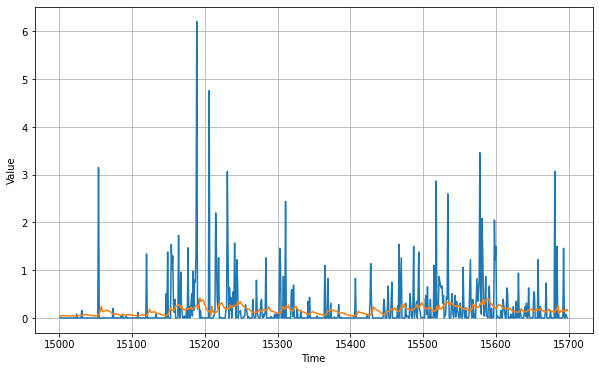

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.24904515

<Figure size 432x288 with 0 Axes>

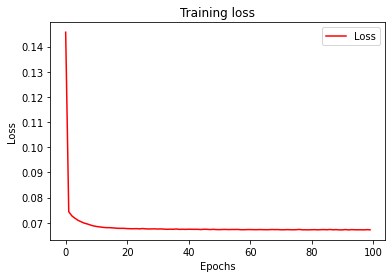

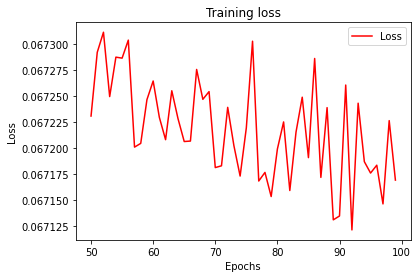

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[50:]
zoomed_epochs = range(50,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast.shape, x_valid.shape)

(698,) (698,)


In [ ]:
print(rnn_forecast)

[0.04146998 0.04259387 0.04486258 0.04674594 0.0496697  0.05051048
 0.05037651 0.04964898 0.04864727 0.04755618 0.04648035 0.04547003
 0.04456728 0.04377547 0.04309493 0.04251998 0.0420416  0.04164908
 0.0413315  0.04107795 0.04087838 0.04072357 0.04060544 0.04051694
 0.04272959 0.04633124 0.05005221 0.05660986 0.05824403 0.05799045
 0.05674657 0.05836831 0.06159864 0.0653882  0.07496328 0.07536812
 0.0734316  0.07037827 0.06695889 0.06353918 0.06029387 0.05730323
 0.05459896 0.0521941  0.0500821  0.04825028 0.04668066 0.045352
 0.04424106 0.04332391 0.04257663 0.04197622 0.04150112 0.04113143
 0.08058979 0.14033608 0.17610376 0.24232537 0.15208772 0.12877163
 0.13976409 0.14249462 0.14980459 0.15722036 0.15701067 0.15389627
 0.15001716 0.14559771 0.13995764 0.13364588 0.12409795 0.10088593
 0.08770012 0.07950384 0.07629126 0.0765617  0.07770129 0.08536325
 0.08312199 0.07898783 0.07425439 0.06961677 0.06535184 0.06154547
 0.05819741 0.05699683 0.05734626 0.05940246 0.0637226  0.066187

In [ ]:
import time
saved_model_path = "/tmp/saved_model/{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} /tmp/converted_model

2021-06-07 11:00:00.168031: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
